## Imports

In [17]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

## Settings

In [18]:
in_folder = '/home/drevital/obstacles_classification_datasets/column/obstacle'
imname = '1645_obstacles_classification_10_2022-10-02T13-17-36_1_0.22.jpg' # No Obstacle
class_name = in_folder.split('/')[-1]

# Parameters used in the diff_metric to diff_coef assignent function
alfa = -3.5
beta = 2.0
gamma = 8
swc = 1.0 # sample weight coefficient
diff_threshold = 50
std_threshold_dist = 0.5 # Distance from std to apply sample_weight correction

# Define Mask Threshold
threshold = 55

# Constand mean, std to check specific values taken from running the whole dataset
mean = {'obstacle': 0.175, 'no_obstacle': 0.078}
std = {'obstacle': 0.102, 'no_obstacle': 0.112}

## Define curve to assign diff_coef according to diff_metric

In [19]:
def diff_metric_to_diff_coef(sigma_dist):
    
    # Correction curve for assigning coefficients
    # Based on Sigmoid
    # adding alpha, beta and gamma controls, as explained at the
    # beginning of this notebook
    
    return 1/(1 + np.exp(-(sigma_dist*alfa-beta)*gamma))

## Calculate sample_weight

In [20]:
im_path = os.path.join(in_folder, imname)
pair = cv2.imread(im_path)

# Generate diff mask            
w = pair.shape[1]
ref = pair[:, :w//2]
current = pair[:, w//2:]
diff = cv2.subtract(ref, current)
agg_rgb = np.stack((diff[:, :, 0], diff[:, :, 1], diff[:, :, 2])).max(0)
_, area_mask = cv2.threshold(agg_rgb, diff_threshold, 255, cv2.THRESH_BINARY)

# Calculate diff_coeff
h = area_mask.shape[0]
w = area_mask.shape[1]
area = h * w
diff_metric = (np.sum(area_mask)/255)/area
# Following is to adjust the direction of distance from std and correction accordingly
# For obstacle - a negative sigma means we are lower than threshold and need correction
# For no obstacle a positive sigma means we are higher than threshold and need correction
sigma_dist_sign = 1.0 if class_name == 'obstacle' else -1.0 
diff_threshold = mean[class_name] + sigma_dist_sign * std_threshold_dist * std[class_name]
sigma_dist = sigma_dist_sign * (diff_metric - diff_threshold)/std[class_name]
diff_coef = diff_metric_to_diff_coef(sigma_dist)
sample_weight = 1.0 + swc * diff_coef

In [21]:
np.sum(area_mask)/255, area

(7168.0, 40000)

In [22]:
(np.sum(area_mask)/255)/area

0.1792

In [23]:
diff_metric

0.1792

In [24]:
mean, std

({'obstacle': 0.175, 'no_obstacle': 0.078},
 {'obstacle': 0.102, 'no_obstacle': 0.112})

In [25]:
mean[class_name] + sigma_dist_sign * std_threshold_dist * std[class_name]

0.22599999999999998

In [26]:
diff_threshold

0.22599999999999998

In [27]:
sigma_dist_sign * (diff_metric - diff_threshold)/std[class_name], sigma_dist

(-0.4588235294117645, -0.4588235294117645)

In [28]:
diff_metric_to_diff_coef(sigma_dist), diff_coef

(0.04097554394977943, 0.04097554394977943)

In [29]:
diff_coef

0.04097554394977943

In [30]:
sample_weight

1.0409755439497794

## Generate <ref, current, mask> triplet from <ref, current> pair

In [31]:

w = pair.shape[1]
ref = pair[:, :w//2]
current = pair[:, w//2:]
diff = cv2.absdiff(current, ref)
agg_rgb = np.stack((diff[:, :, 0], diff[:, :, 1], diff[:, :, 2])).max(0)
_, mask = cv2.threshold(agg_rgb, threshold, 255, cv2.THRESH_BINARY)

# old morphological operations
copyImg = cv2.erode(mask, np.ones((3, 3), np.uint8), iterations=1)  # reduce noise
copyImg = cv2.dilate(copyImg, np.ones((7, 7), np.uint8), iterations=1)
copyImg = cv2.erode(copyImg, np.ones((5, 5), np.uint8), iterations=1)
copyImg = cv2.dilate(copyImg, np.ones((9, 9), np.uint8), iterations=1)
kernel = np.ones((11, 11), np.uint8)  # kernel for dilation

# increase area to an object
copyImg = cv2.dilate(copyImg, kernel, iterations=2)
copyImg = cv2.dilate(copyImg, np.ones((13, 13), np.uint8), iterations=1)
copyImg = cv2.erode(copyImg, np.ones((11, 11), np.uint8), iterations=1)
copyImg = cv2.erode(copyImg, np.ones((5, 5), np.uint8), iterations=1)

mask = copyImg 
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  

concat = cv2.hconcat([ref, current, mask])

## Display Concatenated Image

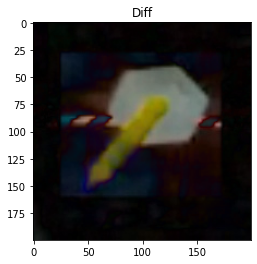

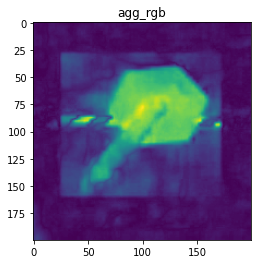

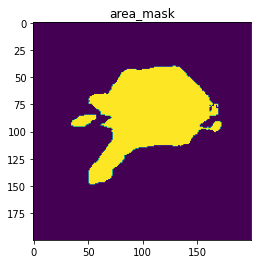

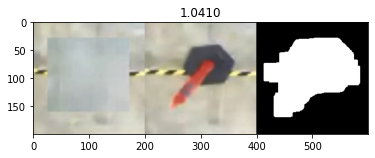

In [32]:
plt.imshow(diff)
plt.title('Diff')
plt.show()

plt.imshow(agg_rgb)
plt.title('agg_rgb')
plt.show()

plt.imshow(area_mask)
plt.title('area_mask')
plt.show()

concat = cv2.cvtColor(concat, cv2.COLOR_BGR2RGB)
plt.imshow(concat)
plt.title(f'{sample_weight:.4f}')
plt.show()